# Import Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import collections
from lmfit import Minimizer, Parameters, report_fit
from lmfit.lineshapes import gaussian, lorentzian, split_lorentzian
from scipy import integrate
from tqdm.notebook import tqdm

In [2]:
df = pd.read_csv('df_t120.csv')
# Use read_csv function to read .csv file.

df.rename(columns={'Unnamed: 0': 'Original Index'}, inplace=True)
# Rename the column label of the 0th column in place.
df

Original Index  Condition  99.739764  104.250978  108.760014  113.264746  \
0                75         19     8955.0      9665.0     10191.0      9675.0   
1                76         19     8749.0      9887.0     10091.0      9634.0   
2                77         19     8960.0      9904.0     10176.0      9571.0   
3                78         19     8876.0     10028.0     10009.0      9536.0   
4                79         19     8864.0      9811.0     10217.0      9282.0   
..              ...        ...        ...         ...         ...         ...   
175            1055         27     8410.0      9351.0      9688.0      9114.0   
176            1056         27     8444.0      9304.0      9525.0      9187.0   
177            1057         27     8506.0      9186.0      9601.0      9056.0   
178            1058         27     8271.0      9390.0      9521.0      9144.0   
179            1059         27     8345.0      9187.0      9747.0      9281.0   

     117.767305  122.267691  126.763784  131.255589  ...  2470.400811  \
0        8765.0      8068.0      7279.0      6638.0  ...        162.0   
1        8738.0      7897.0      7408.0      6674.0  ...        132.0   
2        8900.0      8054.0      7217.0      6458.0  ...        136.0   
3        8867.0      7911.0      7221.0      6500.0  ...        149.0   
4        8756.0      7893.0      7122.0      6456.0  ...         97.0   
..          ...         ...         ...         ...  ...          ...   
175      8499.0      7604.0      6833.0      6305.0  ...         93.0   
176      8053.0      7594.0      6901.0      6351.0  ...        107.0   
177      8387.0      7496.0      6875.0      6411.0  ...         85.0   
178      8419.0      7758.0      7078.0      6325.0  ...         82.0   
179      8268.0      7605.0      6839.0      6280.0  ...         70.0   

     2473.565296  2476.728552  2479.888961  2483.049763  2486.209339  \
0          141.0        193.0        181.0        142.0        174.0   
1           90.0        175.0        142.0        210.0        193.0   
2          128.0        182.0        144.0        197.0         74.0   
3          165.0        192.0        155.0        137.0        148.0   
4          108.0        173.0        127.0        164.0        148.0   
..           ...          ...          ...          ...          ...   
175         66.0        103.0         86.0         66.0         87.0   
176         95.0        151.0         59.0        136.0         50.0   
177         87.0         93.0         66.0        130.0         79.0   
178         69.0        148.0         63.0        111.0         56.0   
179         78.0        165.0        112.0        169.0         81.0   

     2489.366072  2492.523197  2495.677482  2498.827313  
0          187.0        168.0        131.0        128.0  
1          199.0        143.0        115.0        178.0  
2          203.0        131.0        112.0        103.0  
3          167.0        212.0         78.0        178.0  
4          166.0        114.0        141.0        146.0  
..           ...          ...          ...          ...  
175         88.0         97.0         80.0         84.0  
176        125.0        124.0         60.0         69.0  
177        151.0         54.0         54.0         82.0  
178        137.0         65.0         40.0         51.0  
179        150.0         65.0        105.0        133.0  

[180 rows x 638 columns]

# Test Plots and Baseline Correction

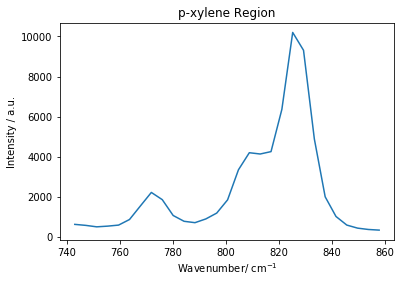

In [3]:
# Extract relevant p-xylene region and Vinyl region from the 1st spectra for
# baseline correction and plot tests.

pxyl_Region = df.iloc[0, 151:180] # Extract 1st spectra at the pxyl region and plot.
pxyl_Region.index = pxyl_Region.index.astype(float) # Change the index type to float.
pxyl_Region.plot()
plt.xlabel('Wavenumber/ cm$^{-1}$')
plt.ylabel('Intensity / a.u.')
plt.title('p-xylene Region')
plt.show()

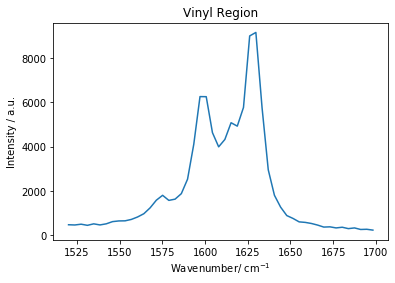

In [4]:
Vinyl_Region = df.iloc[0, 350:400] # Extract 1st spectra at the Vinyl region and plot.
Vinyl_Region.index = Vinyl_Region.index.astype(float) # Change the index type to float.
Vinyl_Region.plot()
plt.xlabel('Wavenumber/ cm$^{-1}$')
plt.ylabel('Intensity / a.u.')
plt.title('Vinyl Region')
plt.show()

# Baseline Subtraction

## Custom

Choose two regions on the spectrum that you want to form the basis for the baseline. The spectrum is based on the truncated region of interest from the raw spectrum.

Choose from the curve above, <10 and >50 to form the x and y values to fit a polynomial line, serving as my baseline values. **Note that the x-axis is the placeholder index location of the truncated spectra, not the actual wavenumbers themselves**

p-xylene Region Baseline Subtraction

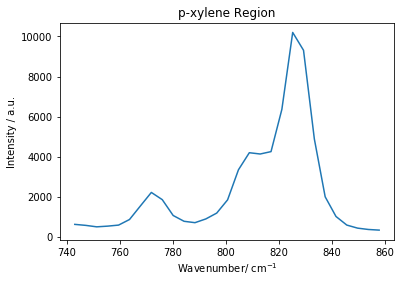

In [5]:
# p-xylene Region Baseline Subtraction
y = df.iloc[0, 151:180]
y.index = y.index.astype('float')
plt.xlabel('Wavenumber/ cm$^{-1}$')
plt.ylabel('Intensity / a.u.')
plt.title('p-xylene Region')
y.plot()
plt.show()

# y is a Series. A pandas Series is a lablled/ indexed 1-D array. Therefore, a single argument of y,
# itself containing the intensity value (y-axis) at the corresponding wavenumber (x-axis) can be plotted. 

# Plot the 1st spectra (1st row) of df_t0.

In [6]:
xbl = [] # x-baseline.

for items in y.index[:5].values.tolist():
    xbl.append(items)

for items in y.index[25:].values.tolist():
    xbl.append(items)

# Recall that y is a Series with intensities labelled by their wavenumbers. y.index gives the Series labels, which are the 
# wavenumbers. y.index[:10] gives the 0th to 9th Series labels and is an index object. Convert the index object to a numpy
# array via y.index[:10].values, then put them into a list via y.index[:10].values.tolist().

# There are 2 for loops for the xbl (x baseline) list because you want the 1st 10 wavenumbers, but you also want the last
# wavenumbers from index 40 onwards. In the end, xbl is a single list containing all wavenumbers from index 0 to 9,
# and then from index 40 onwards. The same ideas apply for ybl, except for the fact that ybl contains intensities.

ybl = [] # y-baseline.

for items in y.values[:5].tolist():
    ybl.append(items)

for items in y.values[25:].tolist():
    ybl.append(items)
    
# y is a Pandas Series. Therefore, y.values immediately gives the values witihn that series, which are the intensities.

In [7]:
# Check that the range of xbl and ybl values makes sense.
xbl_and_ybl = list(zip(xbl, ybl))# Zip xbl and ybl together, then use list function to unpack the zipped object.
xbl_and_ybl

[(743.107581, 610.0),
 (747.235957, 560.0),
 (751.364423, 487.0),
 (755.490999, 522.0),
 (759.613705, 574.0),
 (845.650826, 575.0),
 (849.720613, 422.0),
 (853.788551, 355.0),
 (857.854643, 323.0)]

Running the baseline fit. **(x-values, y-values, polynomial degree)** are the arguments.

In [8]:
blpars = np.polyfit(xbl, ybl, 1)
# blpars contains the baseline parameters; the coefficients which will allow for the baseline polynomial to be defined.
# Fit a polynomial based on the x and y-values chosen for the spectra during the previous step. Thus, given a list of x values
# and its corresponding y-values, fit a polynomial through these points as best as you can. This polynomial will serve as the 
# baseline to be subtracted from the spectra's y-values. 
# numpy.polyfit(x, y, deg)
# np.polyfit: Least squares polynomial fit. Fit a polynomial p(x) = p[0] * x**deg + ... + p[deg] of degree deg to points (x, y).
# Returns a vector of coefficients p that minimises the squared error in the order deg, deg-1, … 0.
# Since degree = 1, we are fitting a straight line.

blfit = np.poly1d(blpars)
# A one-dimensional polynomial class. A convenience class, used to encapsulate “natural” operations on polynomials so that
# said operations may take on their customary form in code. blfit is a function that encompasses information on blpar's vector
# of coefficients derived from the np.polyfit step. It will take an input of x-values, then apply the coefficients to the
# x-values to obtain the best fit polynomial following the p(x) equation defined above.

Plot showing before and after subtraction.

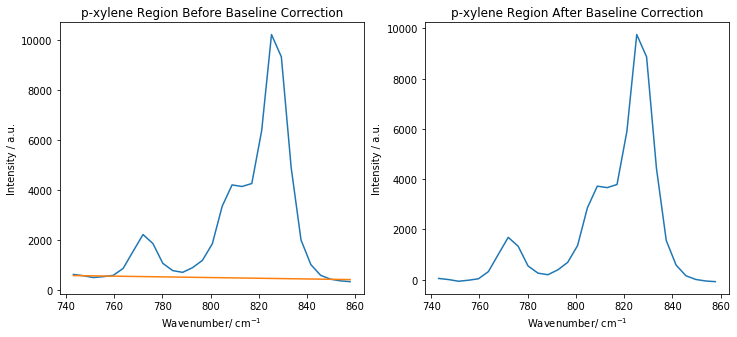

In [9]:
plt.figure(figsize = (12,5))

plt.subplot(1,2,1) # subplot(nrows, ncols, index)
plt.plot(y) # Plot the spectrum using the Series y.
plt.xlabel('Wavenumber/ cm$^{-1}$')
plt.ylabel('Intensity / a.u.')
plt.title('p-xylene Region Before Baseline Correction')
plt.plot(y.index, blfit(y.index))
# Plot the baseline polynomial to be subtracted (orange color). The x-axis will contain the wavenumbers. 
# Therefore y.index(Series labels) is being plotted at the x-axis. The y-axis will be blfit(y.index) because the output of 
# blfit(y.index) contains the y-values of the polynomial that is best fit to the input x-values.

plt.subplot(1,2,2)
plt.xlabel('Wavenumber/ cm$^{-1}$')
plt.ylabel('Intensity / a.u.')
plt.title('p-xylene Region After Baseline Correction')
plt.plot(y.index,(y - blfit(y.index)))
# Plot the baseline corrected spectrum. Subtraction can immediately be done because blfit(y.index) is a numpy array of y-values
# of the best fit polynomial. So the each value in Series y will minus each value in array blfit(y.index),
# to yield a final y value, which is the corrected spectra intensity. 

plt.show()

Vinyl Region Baseline Subtraction

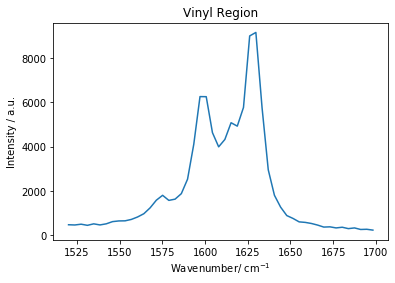

In [10]:
# Vinyl Region Baseline Subtraction
y = df.iloc[0, 350:400]
y.index = y.index.astype('float')
plt.xlabel('Wavenumber/ cm$^{-1}$')
plt.ylabel('Intensity / a.u.')
plt.title('Vinyl Region')
y.plot()
plt.show()

In [11]:
xbl = []

for items in y.index[:10].values.tolist():
    xbl.append(items)

for items in y.index[40:].values.tolist():
    xbl.append(items)
    
ybl = []

for items in y.values[:10].tolist():
    ybl.append(items)

for items in y.values[40:].tolist():
    ybl.append(items)

In [12]:
xbl_and_ybl = list(zip(xbl, ybl))
xbl_and_ybl

[(1520.028312, 474.0),
 (1523.715956, 464.0),
 (1527.400209, 499.0),
 (1531.082889, 448.0),
 (1534.763995, 515.0),
 (1538.441718, 466.0),
 (1542.119683, 516.0),
 (1545.794267, 615.0),
 (1549.465474, 646.0),
 (1553.136926, 651.0),
 (1665.901972, 459.0),
 (1669.507884, 369.0),
 (1673.110491, 380.0),
 (1676.713364, 331.0),
 (1680.311155, 362.0),
 (1683.909212, 299.0),
 (1687.503974, 331.0),
 (1691.097223, 261.0),
 (1694.688961, 270.0),
 (1698.279189, 232.0)]

In [13]:
blpars = np.polyfit(xbl, ybl, 1)
blfit = np.poly1d(blpars)

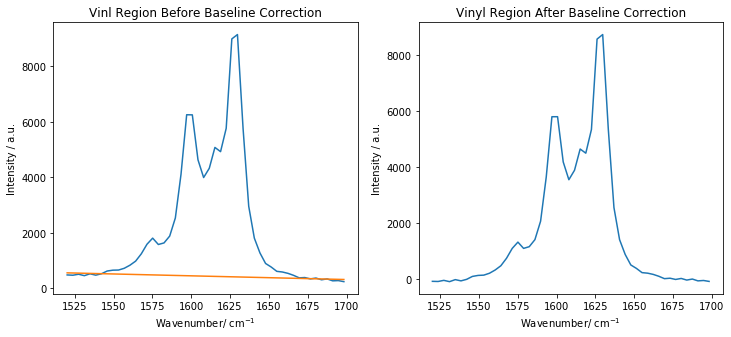

In [14]:
plt.figure(figsize = (12,5))

plt.subplot(1,2,1)
plt.plot(y)
plt.plot(y.index, blfit(y.index))
plt.xlabel('Wavenumber/ cm$^{-1}$')
plt.ylabel('Intensity / a.u.')
plt.title('Vinl Region Before Baseline Correction')

plt.subplot(1,2,2)
plt.plot(y.index,(y - blfit(y.index))) 
plt.xlabel('Wavenumber/ cm$^{-1}$')
plt.ylabel('Intensity / a.u.')
plt.title('Vinyl Region After Baseline Correction')

plt.show()

# Fitting Functions

In [15]:
from lmfit import Minimizer, Parameters, report_fit
from lmfit.lineshapes import gaussian, lorentzian, split_lorentzian

def residuals(pars,x,y):
    
    model =  (lorentzian(x, pars['ampL1'], pars['cenL1'], pars['widL1']) +
              lorentzian(x, pars['ampL2'], pars['cenL2'], pars['widL2']))
    
    return model - y

# Running Curve Fits

In [16]:
df_vinyl = df.iloc[:, 350:400].copy()
df_vinyl.columns = df_vinyl.columns.astype('float')
df_vinyl

1520.028312  1523.715956  1527.400209  1531.082889  1534.763995  \
0          474.0        464.0        499.0        448.0        515.0   
1          458.0        461.0        433.0        468.0        536.0   
2          497.0        513.0        494.0        482.0        529.0   
3          490.0        504.0        485.0        452.0        520.0   
4          419.0        426.0        452.0        454.0        571.0   
..           ...          ...          ...          ...          ...   
175        293.0        336.0        356.0        346.0        447.0   
176        330.0        311.0        286.0        357.0        393.0   
177        361.0        305.0        328.0        295.0        429.0   
178        337.0        333.0        333.0        310.0        412.0   
179        286.0        321.0        357.0        287.0        430.0   

     1538.441718  1542.119683  1545.794267  1549.465474  1553.136926  ...  \
0          466.0        516.0        615.0        646.0        651.0  ...   
1          524.0        564.0        632.0        672.0        643.0  ...   
2          491.0        493.0        549.0        593.0        601.0  ...   
3          537.0        484.0        652.0        598.0        656.0  ...   
4          465.0        573.0        580.0        617.0        667.0  ...   
..           ...          ...          ...          ...          ...  ...   
175        354.0        465.0        539.0        464.0        499.0  ...   
176        342.0        462.0        522.0        519.0        541.0  ...   
177        366.0        410.0        509.0        533.0        492.0  ...   
178        314.0        433.0        488.0        479.0        529.0  ...   
179        386.0        511.0        457.0        632.0        560.0  ...   

     1665.901972  1669.507884  1673.110491  1676.713364  1680.311155  \
0          459.0        369.0        380.0        331.0        362.0   
1          458.0        404.0        402.0        330.0        350.0   
2          430.0        407.0        395.0        316.0        323.0   
3          362.0        449.0        387.0        341.0        315.0   
4          424.0        389.0        387.0        299.0        373.0   
..           ...          ...          ...          ...          ...   
175        359.0        325.0        281.0        230.0        218.0   
176        360.0        313.0        305.0        219.0        234.0   
177        408.0        314.0        297.0        245.0        251.0   
178        355.0        320.0        319.0        249.0        288.0   
179        391.0        316.0        296.0        216.0        277.0   

     1683.909212  1687.503974  1691.097223  1694.688961  1698.279189  
0          299.0        331.0        261.0        270.0        232.0  
1          264.0        308.0        278.0        287.0        196.0  
2          287.0        322.0        249.0        288.0        237.0  
3          289.0        275.0        263.0        299.0        243.0  
4          246.0        349.0        193.0        279.0        210.0  
..           ...          ...          ...          ...          ...  
175        225.0        280.0        227.0        168.0        156.0  
176        219.0        234.0        203.0        170.0        161.0  
177        167.0        237.0        211.0        194.0        124.0  
178        203.0        295.0        168.0        205.0         87.0  
179        202.0        283.0        174.0        225.0        135.0  

[180 rows x 50 columns]

For 2 Lorentzians peak fits within the region of interest:

## Select initial guess parameters, namely amplitude, centre, width of the peaks.

In [17]:
ampL1 = 100000 # Peak Amplitude of 1st Peak
cenL1 = 1599 # Peak location of 1st Peak
widL1 = 10

ampL2 = 100000 # Peak Amplitude of 2nd Peak
cenL2 = 1627 # Peak location of 2nd Peak
widL2 = 6

## Fitting and Plotting (Vinyl Region)

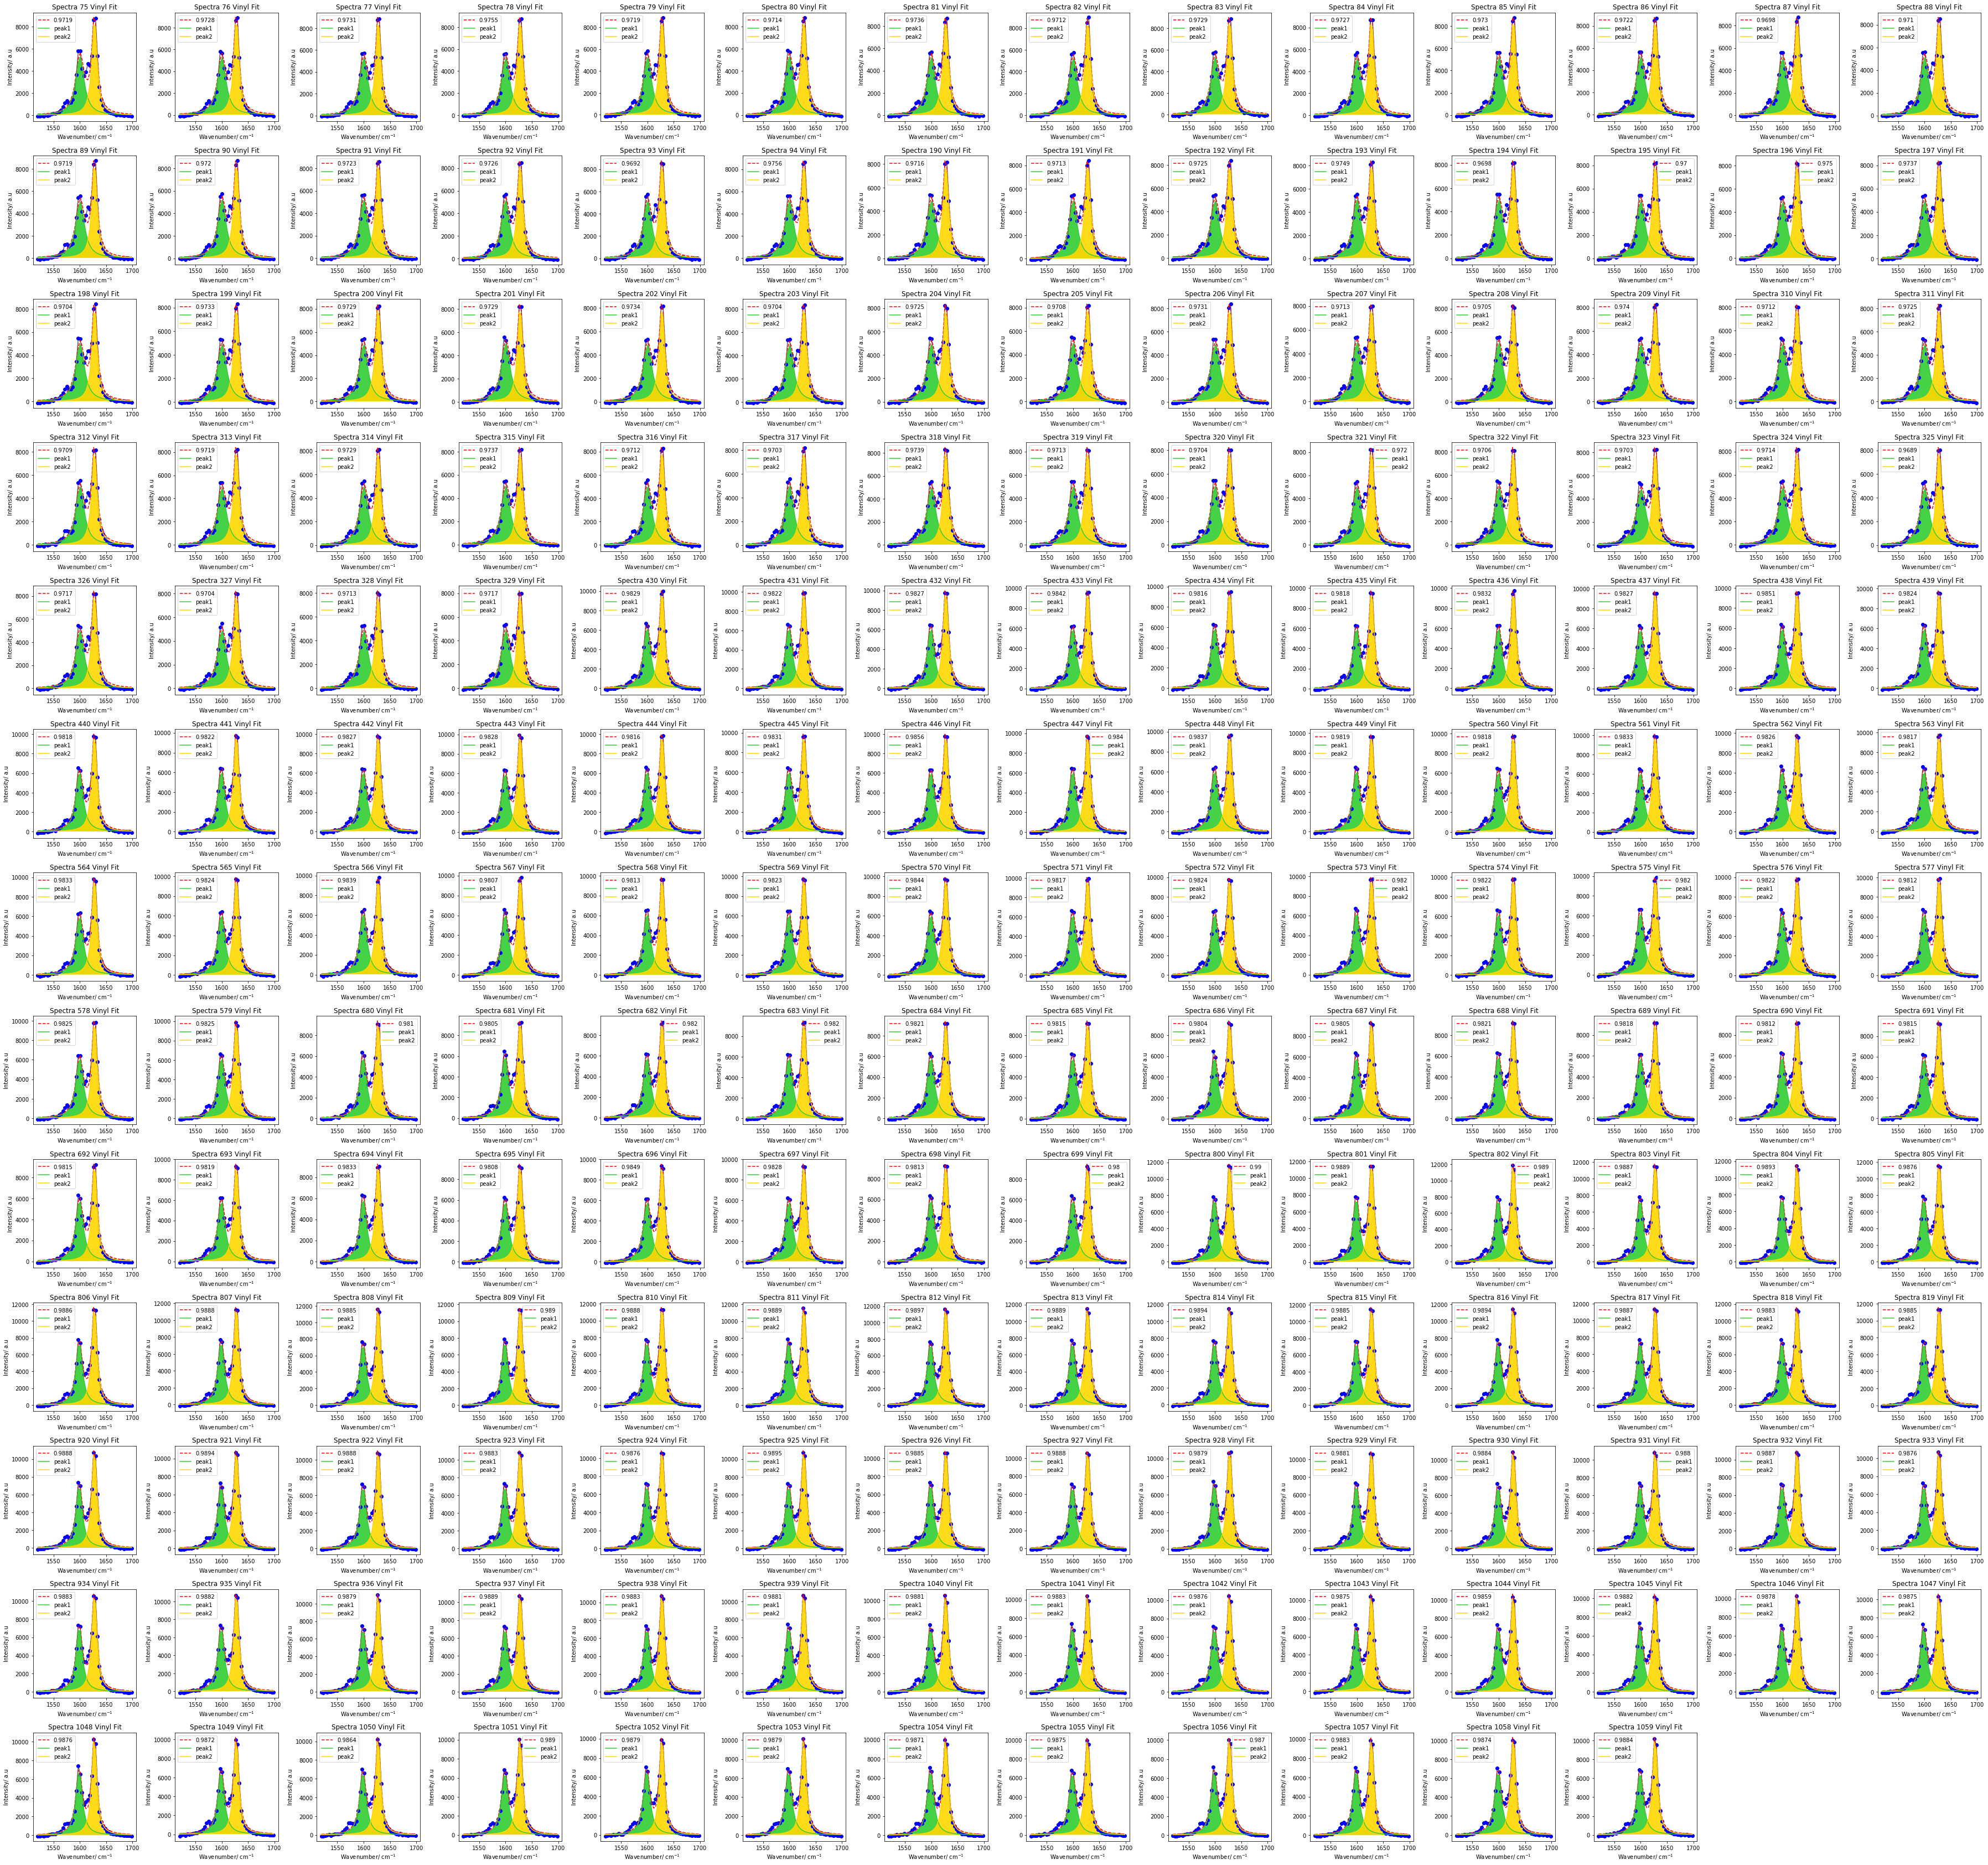

In [18]:
de = collections.deque([])
Area_1 = collections.deque([])
Area_2 = collections.deque([])

pbar = tqdm(total = len(df_vinyl), dynamic_ncols  = True, desc = 'Fitting curves')

plt.figure(figsize = (50,50))

pfit = Parameters()
pfit.add(name='ampL1', value = ampL1, min = 0)
pfit.add(name='ampL2', value = ampL2, min = 0)
pfit.add(name='cenL1', value = cenL1, max = 1605)
pfit.add(name='cenL2', value = cenL2, min = 1620, max = 1640)
pfit.add(name='widL1', value = widL1, min = 0)
pfit.add(name='widL2', value = widL2, min = 0)

for i,item in df_vinyl.iterrows():
    
    x = df_vinyl.columns # Wavenumbers
    
    y = item # Intensities
    
    xbl = []

    for items in y.index[:10].values.tolist():
        xbl.append(items)

    for items in y.index[40:].values.tolist():
        xbl.append(items)


    ybl = []

    for items in y.values[:10].tolist():
        ybl.append(items)

    for items in y.values[40:].tolist():
        ybl.append(items)
    
    blpars = np.polyfit(xbl, ybl, 1)
    blfit = np.poly1d(blpars)
    
    y -= blfit(x) # Corrected Intensities

    mini = Minimizer(residuals, pfit, fcn_args=(x, y))
    out = mini.leastsq()
    best_fit = y + out.residual
    
    fit_params = out.params.valuesdict()
    fit_params['R2'] = r2_score(y,best_fit)
    fit_params['FWHM_L1'] = 2*out.params.valuesdict()['widL1']
    fit_params['FWHM_L2'] = 2*out.params.valuesdict()['widL2']
    fit_params['Height_L1'] = 0.3183099*out.params.valuesdict()['ampL1']/max(2.220446049250313e-16, out.params.valuesdict()['widL1'])
    fit_params['Height_L2'] = 0.3183099*out.params.valuesdict()['ampL2']/max(2.220446049250313e-16, out.params.valuesdict()['widL2'])
    
    
    results = de.append(fit_params)
    
    peak1 = lorentzian(x,out.params.valuesdict()['ampL1'], out.params.valuesdict()['cenL1'], out.params.valuesdict()['widL1'])
    peak2 = lorentzian(x,out.params.valuesdict()['ampL2'], out.params.valuesdict()['cenL2'], out.params.valuesdict()['widL2'])
    
    plt.subplot(np.ceil(np.sqrt(df_vinyl.shape[0])),np.ceil(np.sqrt(df_vinyl.shape[0])),(1+i))
    plt.title('Spectra ' + str(df.loc[i, 'Original Index']) + ' Vinyl Fit')
    plt.xlabel('Wavenumber/ cm$^{-1}$')
    plt.ylabel('Intensity/ a.u')
    plt.plot(x, y, '#606060')
    plt.plot(x, y, 'bo')
    plt.plot(x, best_fit, 'r--', label = str(fit_params['R2'].round(decimals = 4)))
    plt.plot(x, peak1,'#32CD32', label = 'peak1')
    plt.fill_between(x, peak1.min(), peak1, facecolor = '#32CD32', alpha = 0.9)
    plt.plot(x, peak2,'#FFD700', label = 'peak2')
    plt.fill_between(x, peak2.min(), peak2, facecolor = '#FFD700', alpha = 0.9)
    plt.legend(loc='best')
   
    Area_1.append(integrate.simps(peak1, x)) 
    Area_2.append(integrate.simps(peak2, x))
    
    pbar.update(1)
    
pbar.close()
    
plt.tight_layout()
plt.show()

In [19]:
results = pd.DataFrame(de)
results.rename(columns={'R2':'R2_Vinyl'}, inplace=True)
results.describe()

ampL1          ampL2        cenL1        cenL2       widL1  \
count     180.000000     180.000000   180.000000   180.000000  180.000000   
mean   158708.240045  178944.514482  1599.470957  1627.650578    8.516655   
std      6669.357636   17553.626716     0.654513     0.096235    1.059508   
min    144875.151511  148394.155032  1598.510492  1627.386774    7.081523   
25%    154178.810970  162955.611166  1598.858309  1627.600574    7.490597   
50%    157088.246165  181245.543912  1599.304277  1627.663290    8.218346   
75%    161762.671050  188947.433519  1600.204283  1627.713253    9.688182   
max    177234.832456  216668.482108  1600.964908  1627.869142   11.005173   

            widL2    R2_Vinyl     FWHM_L1     FWHM_L2    Height_L1  \
count  180.000000  180.000000  180.000000  180.000000   180.000000   
mean     5.804871    0.980862   17.033310   11.609742  6036.481027   
std      0.202274    0.006857    2.119015    0.404547   889.014615   
min      5.405768    0.968893   14.163045   10.811536  4743.186214   
25%      5.640317    0.972919   14.981194   11.280635  5118.584461   
50%      5.795756    0.982149   16.436692   11.591513  6058.322830   
75%      5.940665    0.987802   19.376363   11.881329  6889.028686   
max      6.284262    0.989976   22.010346   12.568523  7662.187607   

          Height_L2  
count    180.000000  
mean    9851.021575  
std     1257.704802  
min     7983.325870  
25%     8678.630343  
50%    10019.338171  
75%    10655.545998  
max    12323.315113

For 2 Lorentzians peak fits within the region of interest:

In [20]:
Area_2 = pd.Series(Area_2)
labels = df.iloc[:, 0:2]
df_area = pd.concat([labels, Area_2, results['R2_Vinyl']], axis=1)
df_area.rename(columns={0: 'Vinyl Peak Area'}, inplace=True)
df_area

Original Index  Condition  Vinyl Peak Area  R2_Vinyl
0                75         19    158987.603733  0.971894
1                76         19    158437.413619  0.972754
2                77         19    159025.949675  0.973084
3                78         19    159030.456583  0.975479
4                79         19    160914.505567  0.971928
..              ...        ...              ...       ...
175            1055         27    175430.466421  0.987524
176            1056         27    178624.047804  0.987001
177            1057         27    175584.281625  0.988272
178            1058         27    176575.888374  0.987409
179            1059         27    174937.439277  0.988358

[180 rows x 4 columns]

# Fitting and Plotting (p-xylene Region)

In [21]:
df_pxyl = df.iloc[:, 151:180].copy()
df_pxyl.columns = df_pxyl.columns.astype('float')
df_pxyl

743.107581  747.235957  751.364423  755.490999  759.613705  763.734525  \
0         610.0       560.0       487.0       522.0       574.0       853.0   
1         549.0       487.0       457.0       501.0       598.0       826.0   
2         558.0       501.0       419.0       596.0       581.0       891.0   
3         611.0       482.0       484.0       468.0       620.0       802.0   
4         533.0       521.0       467.0       511.0       577.0       864.0   
..          ...         ...         ...         ...         ...         ...   
175       657.0       483.0       544.0       620.0       669.0      1019.0   
176       523.0       516.0       480.0       572.0       714.0       976.0   
177       587.0       503.0       456.0       599.0       713.0       981.0   
178       540.0       505.0       520.0       645.0       618.0      1044.0   
179       599.0       545.0       511.0       602.0       706.0      1046.0   

     767.853459  771.968532  776.081725  780.193037  ...  821.175539  \
0        1533.0      2206.0      1846.0      1054.0  ...      6357.0   
1        1505.0      2166.0      1883.0      1069.0  ...      6218.0   
2        1499.0      2230.0      1866.0      1091.0  ...      6252.0   
3        1489.0      2144.0      1787.0      1169.0  ...      6281.0   
4        1368.0      2201.0      1809.0      1047.0  ...      6207.0   
..          ...         ...         ...         ...  ...         ...   
175      1709.0      2435.0      1949.0      1168.0  ...      4152.0   
176      1781.0      2519.0      1976.0      1132.0  ...      4132.0   
177      1701.0      2459.0      1982.0      1214.0  ...      4153.0   
178      1748.0      2554.0      1927.0      1134.0  ...      4067.0   
179      1759.0      2496.0      1953.0      1130.0  ...      4264.0   

     825.258412  829.341392  833.422514  837.501780  841.577229  845.650826  \
0       10202.0      9310.0      4877.0      1988.0      1005.0       575.0   
1       10257.0      9352.0      4834.0      1915.0       988.0       576.0   
2       10158.0      9483.0      4782.0      1918.0       966.0       593.0   
3       10179.0      9386.0      4885.0      2002.0       944.0       576.0   
4       10381.0      9351.0      4903.0      1917.0       907.0       588.0   
..          ...         ...         ...         ...         ...         ...   
175      6221.0      5305.0      2825.0      1272.0       773.0       449.0   
176      6221.0      5472.0      2711.0      1312.0       740.0       421.0   
177      6164.0      5422.0      2758.0      1250.0       711.0       467.0   
178      6388.0      5535.0      2734.0      1257.0       720.0       428.0   
179      6133.0      5382.0      2721.0      1215.0       666.0       479.0   

     849.720613  853.788551  857.854643  
0         422.0       355.0       323.0  
1         471.0       363.0       382.0  
2         472.0       405.0       297.0  
3         453.0       349.0       292.0  
4         445.0       325.0       282.0  
..          ...         ...         ...  
175       404.0       331.0       309.0  
176       331.0       274.0       292.0  
177       324.0       328.0       274.0  
178       377.0       301.0       299.0  
179       376.0       345.0       316.0  

[180 rows x 29 columns]

In [22]:
def residuals(pars,x,y):
    
    model =  (lorentzian(x, pars['ampL1'], pars['cenL1'], pars['widL1']) +
              lorentzian(x, pars['ampL2'], pars['cenL2'], pars['widL2']) +
              split_lorentzian(x, pars['ampL3'], pars['cenL3'], pars['widL3'],pars['widL4']))
    
    return model - y

In [23]:
ampL1 = 15000
cenL1 = 773 
widL1 = 3

ampL2 = 30000 
cenL2 = 808
widL2 = 5

ampL3 = 110000
cenL3 = 827
widL3 = 7
widL4 = 4

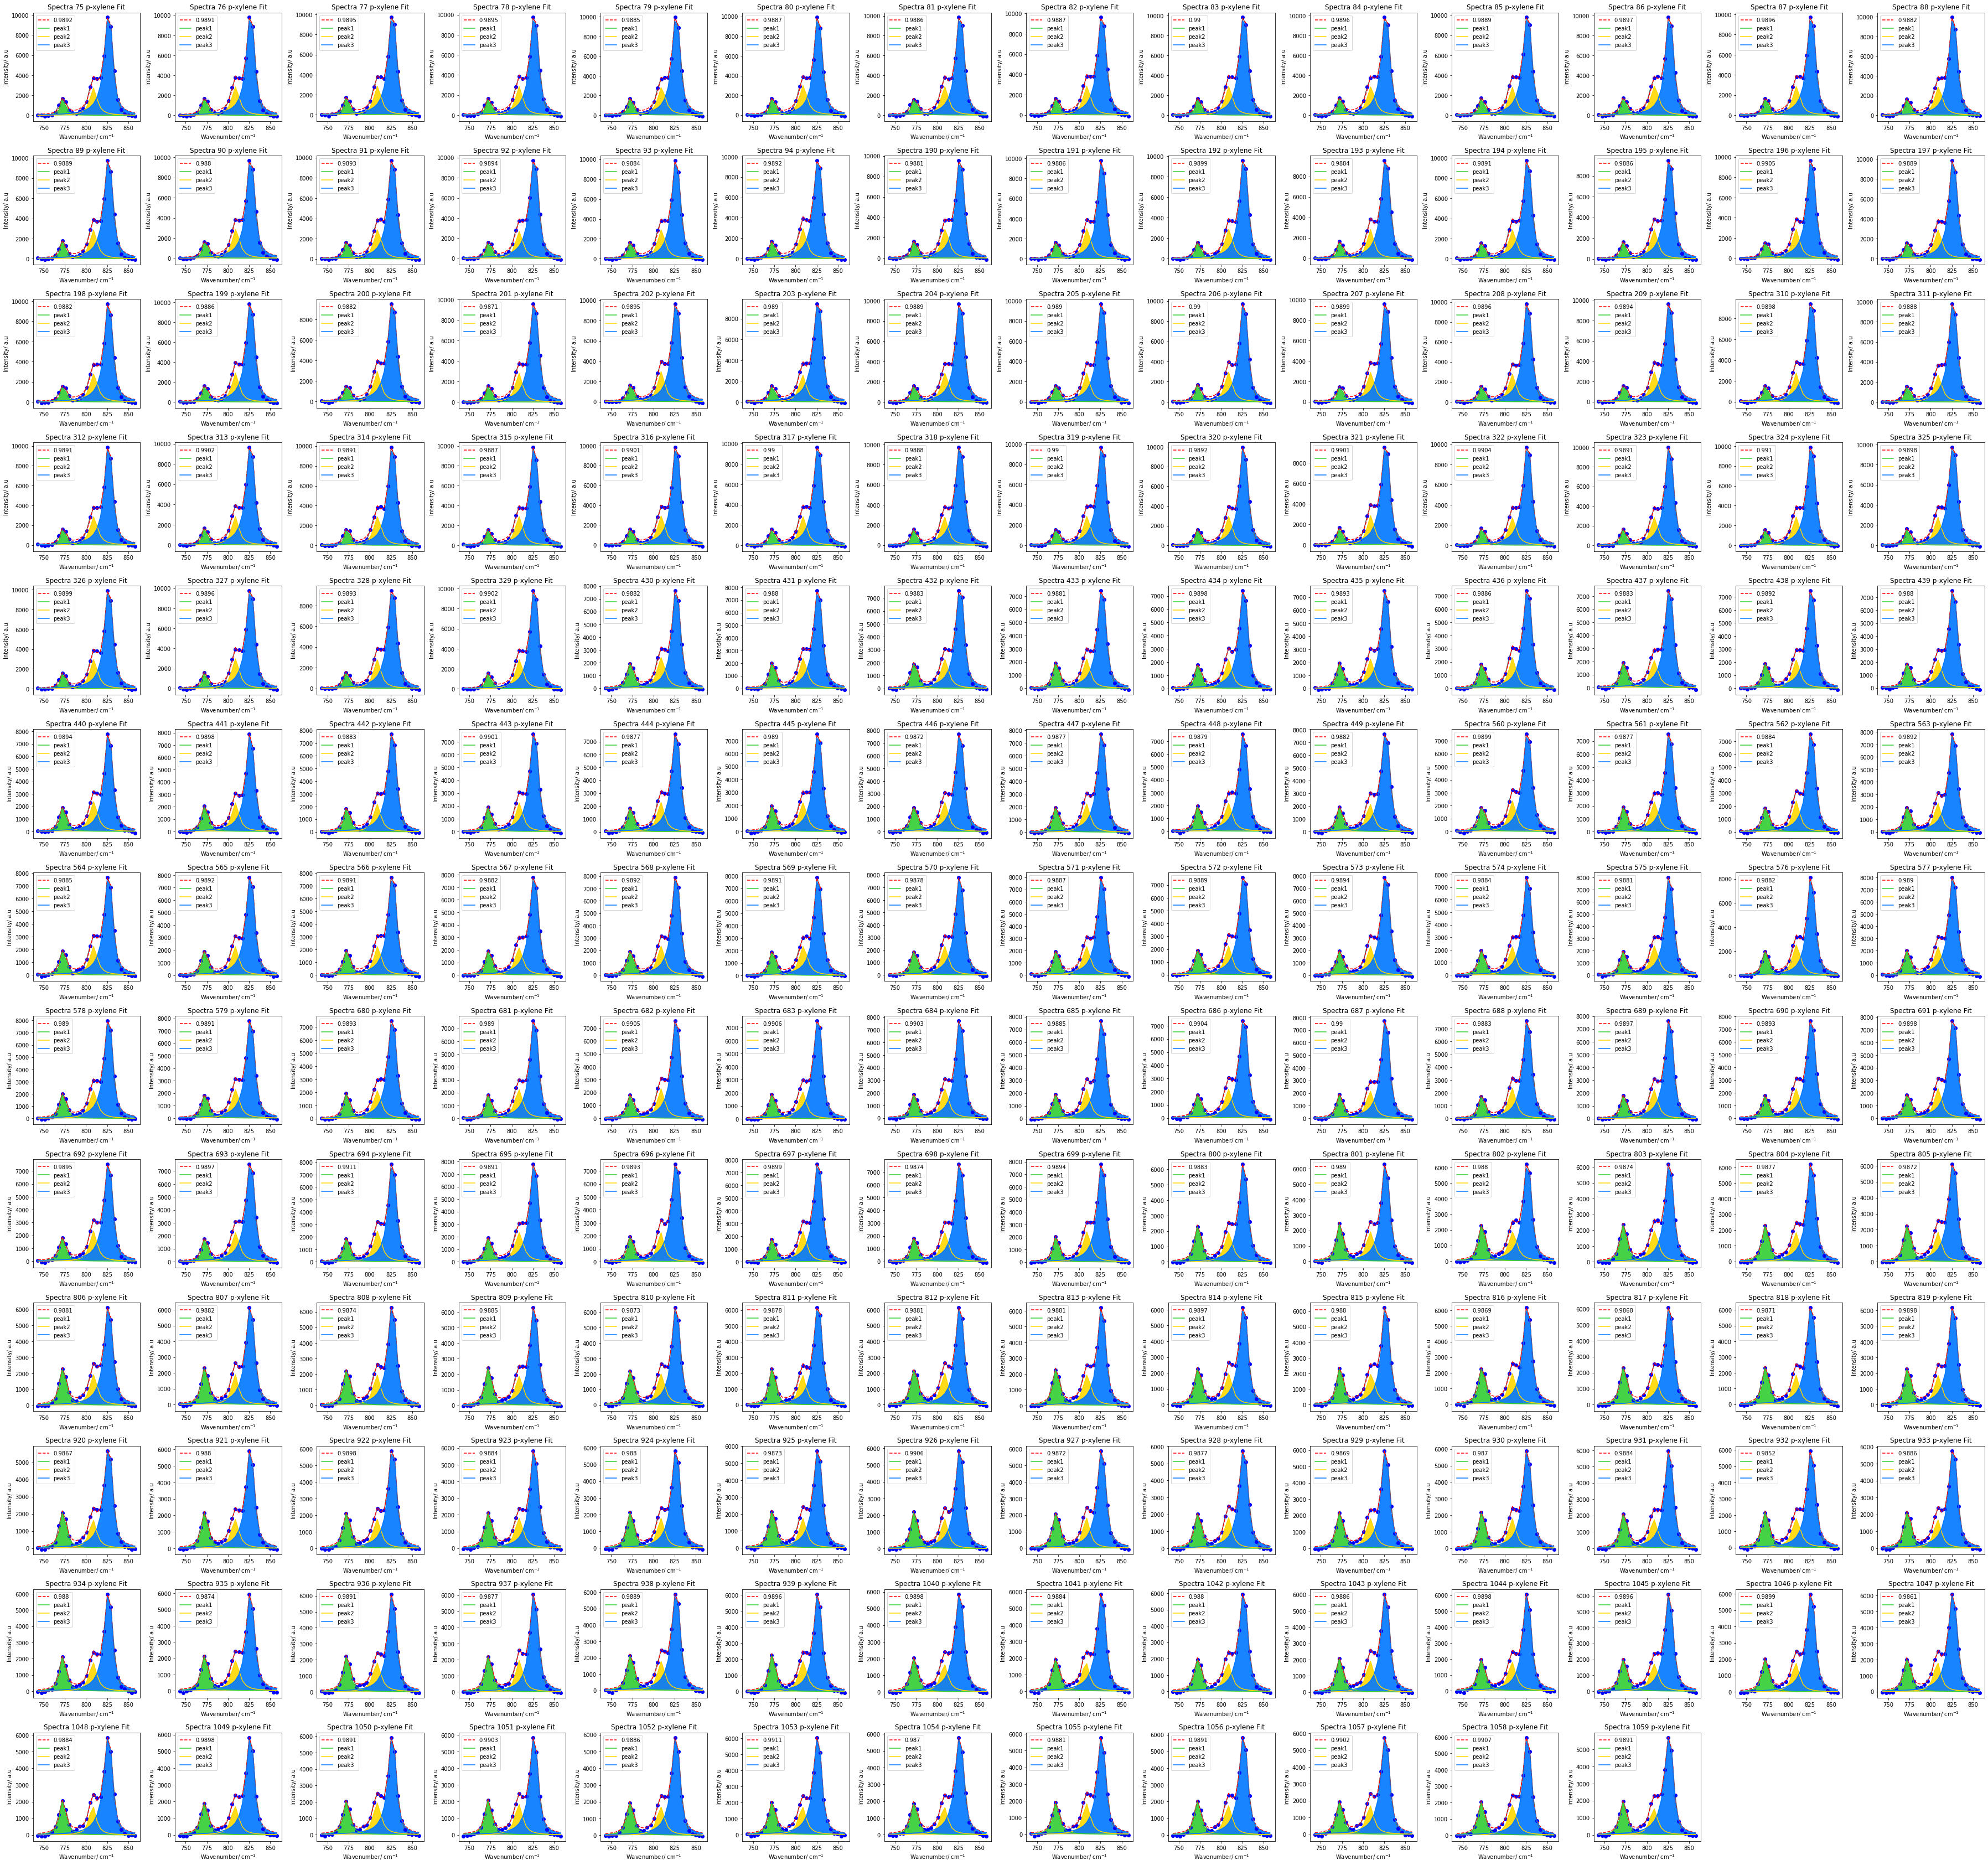

In [24]:
de = collections.deque([])
Area_1 = collections.deque([])
Area_2 = collections.deque([])
Area_3 = collections.deque([])

pbar = tqdm(total = len(df_pxyl), dynamic_ncols  = True, desc = 'Fitting curves')

plt.figure(figsize = (50,50))

pfit = Parameters()
pfit.add(name='ampL1', value = ampL1, min = 0)
pfit.add(name='ampL2', value = ampL2, min = 0)
pfit.add(name='ampL3', value = ampL3, min = 0)
pfit.add(name='cenL1', value = cenL1, min = 770, max = 780)
pfit.add(name='cenL2', value = cenL2, min = 805, max = 815)
pfit.add(name='cenL3', value = cenL3, min = 820, max = 830)
pfit.add(name='widL1', value = widL1, min = 0)
pfit.add(name='widL2', value = widL2, min = 0)
pfit.add(name='widL3', value = widL3, min = 0)
pfit.add(name='widL4', value = widL4, min = 0)

for i,item in df_pxyl.iterrows():
    
    x = df_pxyl.columns # Wavenumbers
    
    y = item # Intensities
    
    xbl = []

    for items in y.index[:5].values.tolist():
        xbl.append(items)

    for items in y.index[25:].values.tolist():
        xbl.append(items)


    ybl = []

    for items in y.values[:5].tolist():
        ybl.append(items)

    for items in y.values[25:].tolist():
        ybl.append(items)
    
    blpars = np.polyfit(xbl, ybl, 1)
    blfit = np.poly1d(blpars)
    
    y -= blfit(x) # Corrected Intensities

    mini = Minimizer(residuals, pfit, fcn_args=(x, y))
    out = mini.leastsq()
    best_fit = y + out.residual
    
    fit_params = out.params.valuesdict()
    fit_params['R2'] = r2_score(y,best_fit)
    fit_params['FWHM_L1'] = 2*out.params.valuesdict()['widL1']
    fit_params['FWHM_L2'] = 2*out.params.valuesdict()['widL2']
    fit_params['FWHM_L3'] = out.params.valuesdict()['widL3'] + out.params.valuesdict()['widL4']
    fit_params['Height_L1'] = 0.318309886*out.params.valuesdict()['ampL1']/max(2.220446049250313e-16, out.params.valuesdict()['widL1'])
    fit_params['Height_L2'] = 0.318309886*out.params.valuesdict()['ampL2']/max(2.220446049250313e-16, out.params.valuesdict()['widL2'])
    fit_params['Height_L3'] = 0.318309886*out.params.valuesdict()['ampL3']/max(2.220446049250313e-16, out.params.valuesdict()['widL3']+out.params.valuesdict()['widL4'])
    
    results = de.append(fit_params)
    
    peak1 = lorentzian(x,out.params.valuesdict()['ampL1'], out.params.valuesdict()['cenL1'], out.params.valuesdict()['widL1'])
    peak2 = lorentzian(x,out.params.valuesdict()['ampL2'], out.params.valuesdict()['cenL2'], out.params.valuesdict()['widL2'])
    peak3 = split_lorentzian(x,out.params.valuesdict()['ampL3'], out.params.valuesdict()['cenL3'], out.params.valuesdict()['widL3'], out.params.valuesdict()['widL4'])
    
    plt.subplot(np.ceil(np.sqrt(df_pxyl.shape[0])),np.ceil(np.sqrt(df_pxyl.shape[0])),(1+i))
    plt.title('Spectra ' + str(df.loc[i, 'Original Index']) + ' p-xylene Fit')
    plt.xlabel('Wavenumber/ cm$^{-1}$')
    plt.ylabel('Intensity/ a.u')
    plt.plot(x, y, '#606060')
    plt.plot(x, y, 'bo')
    plt.plot(x, best_fit, 'r--', label = str(fit_params['R2'].round(decimals = 4)))
    plt.plot(x, peak1,'#32CD32', label = 'peak1')
    plt.fill_between(x, peak1.min(), peak1, facecolor = '#32CD32', alpha = 0.9)
    plt.plot(x, peak2,'#FFD700', label = 'peak2')
    plt.fill_between(x, peak2.min(), peak2, facecolor = '#FFD700', alpha = 0.9)
    plt.plot(x, peak3,'#0077FF', label = 'peak3')
    plt.fill_between(x, peak3.min(), peak3, facecolor = '#0077FF', alpha = 0.9)
    plt.legend(loc='best')
   
    Area_1.append(integrate.simps(peak1, x)) 
    Area_2.append(integrate.simps(peak2, x))
    Area_3.append(integrate.simps(peak3, x))
    
    pbar.update(1)
    
plt.tight_layout()
plt.show()

In [25]:
results = pd.DataFrame(de)
results.rename(columns={'R2':'R2_pxyl'}, inplace=True)
results.describe()

ampL1         ampL2          ampL3       cenL1       cenL2  \
count    180.000000    180.000000     180.000000  180.000000  180.000000   
mean   23514.875200  38980.244007  141819.235799  773.053187  808.787002   
std     4984.937919   7177.938451   28156.552726    0.279314    0.322552   
min    16234.681338  25802.801900  101875.505124  772.369416  807.687568   
25%    18143.337265  32999.169543  111266.799660  772.868865  808.605958   
50%    23496.767921  38175.139585  140036.684660  773.062283  808.814843   
75%    27932.205759  45986.658452  175103.426888  773.231115  809.020668   
max    32670.111243  54130.803247  182222.774467  773.668113  809.471081   

            cenL3       widL1       widL2       widL3       widL4     R2_pxyl  \
count  180.000000  180.000000  180.000000  180.000000  180.000000  180.000000   
mean   827.405326    3.785518    5.369360    6.540007    4.286642    0.988850   
std      0.121411    0.471741    0.223872    0.255700    0.095769    0.001015   
min    827.101405    2.637136    4.775126    5.897460    3.973704    0.985201   
25%    827.324697    3.435548    5.207395    6.354058    4.219929    0.988160   
50%    827.420284    3.843958    5.351246    6.548517    4.295993    0.988977   
75%    827.495777    4.192534    5.499665    6.694926    4.346175    0.989600   
max    827.632691    4.553541    6.029405    7.410958    4.524411    0.991103   

          FWHM_L1     FWHM_L2     FWHM_L3    Height_L1    Height_L2  \
count  180.000000  180.000000  180.000000   180.000000   180.000000   
mean     7.571036   10.738720   10.826649  1960.789924  2313.580946   
std      0.943482    0.447743    0.253557   222.298904   430.792950   
min      5.274273    9.550253   10.189775  1498.178810  1543.713476   
25%      6.871096   10.414790   10.670535  1800.057061  1911.151254   
50%      7.687917   10.702492   10.828399  1937.746012  2285.104102   
75%      8.385067   10.999330   11.001981  2073.009755  2813.204841   
max      9.107081   12.058809   11.516488  2480.177085  2996.439384   

         Height_L3  
count   180.000000  
mean   4174.340775  
std     846.904545  
min    3004.663388  
25%    3279.338001  
50%    4101.935017  
75%    5188.206717  
max    5350.110018

In [26]:
df_area = pd.concat([df_area, pd.Series(Area_3), results['R2_pxyl']], axis=1)
df_area.rename(columns={0: 'pxyl Peak Area'}, inplace=True)
df_area

Original Index  Condition  Vinyl Peak Area  R2_Vinyl  pxyl Peak Area  \
0                75         19    158987.603733  0.971894   169217.334953   
1                76         19    158437.413619  0.972754   163728.180883   
2                77         19    159025.949675  0.973084   164335.750515   
3                78         19    159030.456583  0.975479   168176.521412   
4                79         19    160914.505567  0.971928   164633.251863   
..              ...        ...              ...       ...             ...   
175            1055         27    175430.466421  0.987524    97821.320887   
176            1056         27    178624.047804  0.987001    98954.526285   
177            1057         27    175584.281625  0.988272   100716.378790   
178            1058         27    176575.888374  0.987409    97586.529856   
179            1059         27    174937.439277  0.988358   101786.554623   

      R2_pxyl  
0    0.989227  
1    0.989107  
2    0.989531  
3    0.989538  
4    0.988544  
..        ...  
175  0.988058  
176  0.989075  
177  0.990209  
178  0.990692  
179  0.989150  

[180 rows x 6 columns]

In [27]:
# Keep only columns with R2 values above a threshold.
df_area = df_area[(df_area['R2_Vinyl'] > 0.96) & (df_area['R2_pxyl'] > 0.96)]

# Normalization
df_area['Vinyl Divide pxyl'] =  df_area['Vinyl Peak Area'] / df_area['pxyl Peak Area']

df_area

Original Index  Condition  Vinyl Peak Area  R2_Vinyl  pxyl Peak Area  \
0                75         19    158987.603733  0.971894   169217.334953   
1                76         19    158437.413619  0.972754   163728.180883   
2                77         19    159025.949675  0.973084   164335.750515   
3                78         19    159030.456583  0.975479   168176.521412   
4                79         19    160914.505567  0.971928   164633.251863   
..              ...        ...              ...       ...             ...   
175            1055         27    175430.466421  0.987524    97821.320887   
176            1056         27    178624.047804  0.987001    98954.526285   
177            1057         27    175584.281625  0.988272   100716.378790   
178            1058         27    176575.888374  0.987409    97586.529856   
179            1059         27    174937.439277  0.988358   101786.554623   

      R2_pxyl  Vinyl Divide pxyl  
0    0.989227           0.939547  
1    0.989107           0.967686  
2    0.989531           0.967689  
3    0.989538           0.945616  
4    0.988544           0.977412  
..        ...                ...  
175  0.988058           1.793377  
176  0.989075           1.805112  
177  0.990209           1.743354  
178  0.990692           1.809429  
179  0.989150           1.718669  

[180 rows x 7 columns]

In [28]:
# View the summary statistics
df_area_stats = df_area[['Condition', 'Vinyl Divide pxyl']].groupby('Condition').describe()
df_area_stats

Vinyl Divide pxyl                                                    \
                      count      mean       std       min       25%       50%   
Condition                                                                       
19                     20.0  0.948431  0.021959  0.911547  0.935356  0.944198   
20                     20.0  0.910970  0.024064  0.864149  0.896662  0.909361   
21                     20.0  0.883105  0.016553  0.848318  0.875841  0.884352   
22                     20.0  1.347367  0.026888  1.303055  1.335142  1.346445   
23                     20.0  1.325808  0.034479  1.287609  1.303701  1.309282   
24                     20.0  1.275764  0.026582  1.212728  1.258028  1.279167   
25                     20.0  1.929525  0.037915  1.875035  1.903461  1.923331   
26                     20.0  1.891426  0.033103  1.819605  1.874615  1.892187   
27                     20.0  1.770182  0.038276  1.712810  1.745143  1.762618   

                               
                75%       max  
Condition                      
19         0.965665  0.999269  
20         0.919734  0.970875  
21         0.896062  0.908573  
22         1.357868  1.431367  
23         1.336876  1.394131  
24         1.290954  1.320610  
25         1.947888  2.007797  
26         1.907878  1.983710  
27         1.801792  1.850878

In [29]:
mean = df_area_stats['Vinyl Divide pxyl', 'mean'].values
std = df_area_stats['Vinyl Divide pxyl', 'std'].values
condition = range(19,28)

In [30]:
df_ratio = pd.DataFrame({'Condition':condition, 'Mean Ratio':mean, 'Standard Deviation': std})
df_ratio

Condition  Mean Ratio  Standard Deviation
0         19    0.948431            0.021959
1         20    0.910970            0.024064
2         21    0.883105            0.016553
3         22    1.347367            0.026888
4         23    1.325808            0.034479
5         24    1.275764            0.026582
6         25    1.929525            0.037915
7         26    1.891426            0.033103
8         27    1.770182            0.038276

In [31]:
df_ratio.to_csv(r'C:\Users\Tan Jin Da\Desktop\High Throughput Experiments Data\201022 High Throughput Experiment Conditions 19 to 27\Online Raman\df_t120_ratio.csv')